KeyboardInterrupt: 

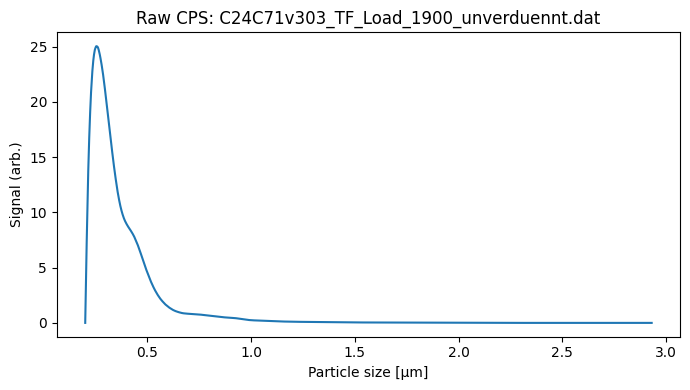

In [10]:
# ============================================
# CPS/DCS batch parser + bi-(log)normal fitting
# Notebook-local runner that targets a sibling
# dataset folder and writes outputs there.
# ============================================

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import lognorm, norm
from numpy import trapz

# =======================
# CONFIG — EDIT AS NEEDED
# =======================
# Set this to a sibling folder name (relative to the notebook's parent)
# or to an absolute path. All outputs (plots, fits, summary) go inside it.
DATASET_FOLDER = "data"     # e.g., "cps_batch_01" or "/abs/path/to/data"

METADATA_LINES = 21                 # lines to skip at top of each .dat (None → auto-detect)
UNIT = "um"                         # "um" or "nm" for the input .dat files
MODEL = "gaussian"                  # "lognormal" or "gaussian"
SMOOTH = False                      # visual smoothing only (doesn't affect fitting)

# Literature-ish peak locations (in micrometers); code converts if UNIT == "nm"
MU_IB_UM    = 0.48                  # IBs ~ 0.48 µm
MU_CELL_UM  = 0.85                  # Intact cells ~ 0.85 µm
ALLOW_SHIFT = 0.20                  # allow ±20% around these means during fitting

# Bounds for peak width (sigma for Gaussian; shape s for Lognormal)
SIGMA_BOUNDS_GAUSS = (1e-3, 0.50)   # µm
S_BOUNDS_LOGN      = (0.05, 0.80)   # dimensionless

# If area of 2nd peak < this fraction of total, treat as single-peak
SECOND_PEAK_MIN_FRAC = 0.02

# Figure export dpi (use 600 for publication quality)
FIG_DPI = 600

# =======================
# Paths & folders
# =======================
def resolve_data_dir(name_or_path: str) -> Path:
    """Resolve the dataset folder:
    - If absolute path → use as-is.
    - Else treat as a subfolder of the notebook's directory.
    """
    p = Path(name_or_path)
    if p.is_absolute():
        return p
    nb_dir = Path.cwd()               # notebook's directory
    return nb_dir / name_or_path      # SAME folder (subfolder) as notebook


DATA_DIR  = resolve_data_dir(DATASET_FOLDER)
PLOTS_DIR = DATA_DIR / "plots"
FITS_DIR  = DATA_DIR / "fits"

def ensure_dirs():
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    PLOTS_DIR.mkdir(exist_ok=True)
    FITS_DIR.mkdir(exist_ok=True)

# =======================
# Helpers
# =======================
def _autodetect_dat_start(lines, min_cols=2):
    """Find first line that looks like 'two floats ...' to start data."""
    pat = re.compile(r"^[ \t]*([-+]?\d+(\.\d+)?([eE][-+]?\d+)?)([ \t]+)([-+]?\d+(\.\d+)?([eE][-+]?\d+)?).*$")
    for i, ln in enumerate(lines):
        if pat.match(ln):
            return i
    return None

def read_cps_dat(path, metadata_lines=METADATA_LINES):
    """Return x (µm), y arrays from a CPS .dat. Assumes two columns: size, signal."""
    txt = path.read_text(errors="ignore").splitlines()
    if metadata_lines is None:
        start = _autodetect_dat_start(txt)
        if start is None:
            raise ValueError(f"Could not detect data start in {path}")
    else:
        start = metadata_lines
    data = []
    for ln in txt[start:]:
        if not ln.strip():
            continue
        parts = re.split(r"[,\t; ]+", ln.strip())
        if len(parts) < 2:
            continue
        try:
            x = float(parts[0]); y = float(parts[1])
            data.append((x, y))
        except ValueError:
            continue
    if not data:
        raise ValueError(f"No numeric rows parsed in {path}")
    arr = np.array(data, dtype=float)
    x, y = arr[:,0], arr[:,1]
    # enforce increasing x and non-negative y
    idx = np.argsort(x)
    x = x[idx]; y = np.clip(y[idx], 0, None)
    # unit normalization to micrometers internally
    if UNIT.lower() == "nm":
        x_um = x / 1000.0
    elif UNIT.lower() == "um":
        x_um = x
    else:
        raise ValueError("UNIT must be 'um' or 'nm'")
    return x_um, y

def roll_mean(a, w=5):
    if w <= 1: return a
    s = np.convolve(a, np.ones(w), mode='same')
    return s / np.clip(np.convolve(np.ones_like(a), np.ones(w), mode='same'), 1, None)

# Models
def lognormal_mix(x, A1, m1, s1, A2, m2, s2, c0):
    # s = shape (>0); scale = m; pdf returns density; multiply by amplitude
    return (A1*lognorm.pdf(x, s1, scale=m1) +
            A2*lognorm.pdf(x, s2, scale=m2) + c0)

def gaussian_mix(x, A1, m1, s1, A2, m2, s2, c0):
    return (A1*norm.pdf(x, loc=m1, scale=s1) +
            A2*norm.pdf(x, loc=m2, scale=s2) + c0)

def one_lognormal(x, A1, m1, s1, c0):
    return A1*lognorm.pdf(x, s1, scale=m1) + c0

def one_gaussian(x, A1, m1, s1, c0):
    return A1*norm.pdf(x, loc=m1, scale=s1) + c0

def initial_guesses(x, y):
    # crude: use literature means; amplitudes ~ fractions of max
    mu_ib = MU_IB_UM
    mu_cell = MU_CELL_UM
    A1 = y.max() * 0.8
    A2 = y.max() * 0.6
    if MODEL == "lognormal":
        s1 = np.clip(0.20, *S_BOUNDS_LOGN)
        s2 = np.clip(0.20, *S_BOUNDS_LOGN)
    else:
        s1 = np.clip(0.10, *SIGMA_BOUNDS_GAUSS)
        s2 = np.clip(0.15, *SIGMA_BOUNDS_GAUSS)
    c0 = max(0.0, np.percentile(y, 1))
    return (A1, mu_ib, s1, A2, mu_cell, s2, c0)

def bounds_for_two_peak():
    mu_ib = MU_IB_UM
    mu_cell = MU_CELL_UM
    lo_mu1 = mu_ib * (1 - ALLOW_SHIFT)
    hi_mu1 = mu_ib * (1 + ALLOW_SHIFT)
    lo_mu2 = mu_cell * (1 - ALLOW_SHIFT)
    hi_mu2 = mu_cell * (1 + ALLOW_SHIFT)

    if MODEL == "lognormal":
        lo = [0, lo_mu1, S_BOUNDS_LOGN[0], 0, lo_mu2, S_BOUNDS_LOGN[0], 0]
        hi = [np.inf, hi_mu1, S_BOUNDS_LOGN[1], np.inf, hi_mu2, S_BOUNDS_LOGN[1], np.inf]
    else:
        lo = [0, lo_mu1, SIGMA_BOUNDS_GAUSS[0], 0, lo_mu2, SIGMA_BOUNDS_GAUSS[0], 0]
        hi = [np.inf, hi_mu1, SIGMA_BOUNDS_GAUSS[1], np.inf, hi_mu2, SIGMA_BOUNDS_GAUSS[1], np.inf]
    return (lo, hi)

def bounds_for_one_peak():
    mu_ib = MU_IB_UM
    lo_mu1 = mu_ib * (1 - ALLOW_SHIFT)
    hi_mu1 = mu_ib * (1 + ALLOW_SHIFT)
    if MODEL == "lognormal":
        lo = [0, lo_mu1, S_BOUNDS_LOGN[0], 0]
        hi = [np.inf, hi_mu1, S_BOUNDS_LOGN[1], np.inf]
    else:
        lo = [0, lo_mu1, SIGMA_BOUNDS_GAUSS[0], 0]
        hi = [np.inf, hi_mu1, SIGMA_BOUNDS_GAUSS[1], np.inf]
    return (lo, hi)

def fit_curve(x, y):
    # try two-peak first, then fallback to one-peak if second is negligible
    p0 = initial_guesses(x, y)
    f = lognormal_mix if MODEL == "lognormal" else gaussian_mix
    bounds = bounds_for_two_peak()
    try:
        popt, pcov = curve_fit(f, x, y, p0=p0, bounds=bounds, maxfev=100000)
        # assess second peak area (numerical integration over measured x)
        A1, m1, s1, A2, m2, s2, c0 = popt
        if MODEL == "lognormal":
            y1 = A1*lognorm.pdf(x, s1, scale=m1)
            y2 = A2*lognorm.pdf(x, s2, scale=m2)
        else:
            y1 = A1*norm.pdf(x, loc=m1, scale=s1)
            y2 = A2*norm.pdf(x, loc=m2, scale=s2)
        area1 = trapz(y1, x)
        area2 = trapz(y2, x)
        if area2 / max(area1 + area2, 1e-12) < SECOND_PEAK_MIN_FRAC:
            # fallback to one peak near IB
            f1 = one_lognormal if MODEL == "lognormal" else one_gaussian
            p01 = (A1, m1, s1, c0)
            b1 = bounds_for_one_peak()
            popt1, pcov1 = curve_fit(f1, x, y, p0=p01, bounds=b1, maxfev=100000)
            return {"kind":"one", "popt":popt1, "pcov":pcov1}
        return {"kind":"two", "popt":popt, "pcov":pcov}
    except Exception:
        # last resort: one-peak fit around IB
        f1 = one_lognormal if MODEL == "lognormal" else one_gaussian
        b1 = bounds_for_one_peak()
        p01 = (p0[0], p0[1], p0[2], p0[-1])
        popt1, pcov1 = curve_fit(f1, x, y, p0=p01, bounds=b1, maxfev=100000)
        return {"kind":"one", "popt":popt1, "pcov":pcov1}

def compute_areas(x, fitres):
    if fitres["kind"] == "two":
        A1, m1, s1, A2, m2, s2, c0 = fitres["popt"]
        if MODEL == "lognormal":
            y1 = A1*lognorm.pdf(x, s1, scale=m1)
            y2 = A2*lognorm.pdf(x, s2, scale=m2)
        else:
            y1 = A1*norm.pdf(x, loc=m1, scale=s1)
            y2 = A2*norm.pdf(x, loc=m2, scale=s2)
        area1 = trapz(y1, x); area2 = trapz(y2, x)
        return area1, area2, y1, y2, c0
    else:
        A1, m1, s1, c0 = fitres["popt"]
        if MODEL == "lognormal":
            y1 = A1*lognorm.pdf(x, s1, scale=m1)
        else:
            y1 = A1*norm.pdf(x, loc=m1, scale=s1)
        area1 = trapz(y1, x)
        return area1, 0.0, y1, np.zeros_like(x), c0

# =======================
# Run
# =======================
ensure_dirs()
rows = []
files = sorted(DATA_DIR.glob("*.dat"))

if not files:
    print(f"No .dat files found in {DATA_DIR.resolve()}")

for fp in files:
    try:
        x_um, y = read_cps_dat(fp)
        x_plot = x_um * (1000.0 if UNIT.lower()=="nm" else 1.0)  # plot in original unit
        unit_label = "nm" if UNIT.lower()=="nm" else "µm"

        # (Optional) smooth for nicer raw plot (fit uses original y)
        y_smooth = roll_mean(y, 7) if SMOOTH else y

        # --- Raw plot
        plt.figure(figsize=(7,4))
        plt.plot(x_plot, y_smooth)
        plt.xlabel(f"Particle size [{unit_label}]")
        plt.ylabel("Signal (arb.)")
        plt.title(f"Raw CPS: {fp.name}")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"{fp.stem}_raw.png", dpi=FIG_DPI)
        plt.close()

        # --- Fit
        fitres = fit_curve(x_um, y)
        area1, area2, y1, y2, c0 = compute_areas(x_um, fitres)
        total_area = max(area1 + area2, 1e-12)

        # Map components to IB/cell by mean location
        if fitres["kind"] == "two":
            A1, m1, s1, A2, m2, s2, c0p = fitres["popt"]
            cell_first = (abs(m1 - MU_CELL_UM) < abs(m2 - MU_CELL_UM))
            if cell_first:
                area_cells, area_IBs = area1, area2
                m_cell, m_ib = m1, m2
            else:
                area_cells, area_IBs = area2, area1
                m_cell, m_ib = m2, m1
        else:
            A1, m1, s1, c0p = fitres["popt"]
            area_cells, area_IBs = 0.0, area1  # assume single peak = IBs only
            m_cell, m_ib = np.nan, m1

        intact_frac = area_cells / total_area if total_area > 0 else 0.0
        lysis_eff = 1.0 - intact_frac

        # --- Fit overlay (in original units)
        x_dense_um = np.linspace(x_um.min(), x_um.max(), 1500)
        if fitres["kind"] == "two":
            y_fit = (lognormal_mix if MODEL=="lognormal" else gaussian_mix)(x_dense_um, *fitres["popt"])
        else:
            y_fit = (one_lognormal if MODEL=="lognormal" else one_gaussian)(x_dense_um, *fitres["popt"])

        # components for shading
        x_dense_plot = x_dense_um * (1000.0 if UNIT.lower()=="nm" else 1.0)
        plt.figure(figsize=(7,4))
        plt.plot(x_plot, y, label="raw")
        plt.plot(x_dense_plot, y_fit, label="fit")

        if fitres["kind"] == "two":
            if MODEL == "lognormal":
                comp1 = fitres["popt"][0]*lognorm.pdf(x_dense_um, fitres["popt"][2], scale=fitres["popt"][1])
                comp2 = fitres["popt"][3]*lognorm.pdf(x_dense_um, fitres["popt"][5], scale=fitres["popt"][4])
            else:
                comp1 = fitres["popt"][0]*norm.pdf(x_dense_um, loc=fitres["popt"][1], scale=fitres["popt"][2])
                comp2 = fitres["popt"][3]*norm.pdf(x_dense_um, loc=fitres["popt"][4], scale=fitres["popt"][5])

            # assign which is cells for legend clarity
            if abs(fitres["popt"][1] - MU_CELL_UM) < abs(fitres["popt"][4] - MU_CELL_UM):
                comp_cells, comp_ibs = comp1, comp2
            else:
                comp_cells, comp_ibs = comp2, comp1

            plt.fill_between(x_dense_plot, 0, comp_cells, alpha=0.25, label="cells")
            plt.fill_between(x_dense_plot, 0, comp_ibs,   alpha=0.25, label="IBs")

        plt.xlabel(f"Particle size [{unit_label}]")
        plt.ylabel("Signal (arb.)")
        plt.title(f"Fit: {fp.name}\nLysis = {lysis_eff:.3f}, Intact cells = {intact_frac:.3f}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(FITS_DIR / f"{fp.stem}_fit.png", dpi=FIG_DPI)
        plt.close()

        rows.append({
            "file": fp.name,
            "unit": unit_label,
            "model": MODEL,
            "kind": fitres["kind"],
            "mu_IB_target_um": MU_IB_UM,
            "mu_cell_target_um": MU_CELL_UM,
            "m_ib_um": float(m_ib),
            "m_cell_um": float(m_cell) if not np.isnan(m_cell) else None,
            "area_IBs": float(area_IBs),
            "area_cells": float(area_cells),
            "area_total": float(total_area),
            "intact_fraction": float(intact_frac),
            "lysis_efficiency": float(lysis_eff)
        })

    except Exception as e:
        print(f"[WARN] {fp.name}: {e}")

summary = pd.DataFrame(rows)
summary_path = DATA_DIR / "cps_summary.xlsx"
summary.to_excel(summary_path, index=False)
print(f"Done. Plots → {PLOTS_DIR.resolve()}, fits → {FITS_DIR.resolve()}, summary → {summary_path.resolve()}")
display(summary.head(10))
